In [1]:
import pandas as pd
import numpy as np

In [25]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

from IPython.display import display
pd.set_option('display.max_columns', None)

from sklearn.metrics import roc_auc_score

In [40]:
import lightgbm

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Reading Data
data = pd.read_feather("C:/Users/Hp/OneDrive/Desktop/churn model/final_2015_v19")
data.shape

(239551, 210)

In [3]:
# Collecting useless columns for dropping them later
# na > 70%
drop_cols = []
for i in data.columns:
    if(data[i].isna().sum() > (data.shape[0])*0.7):
        drop_cols.append(i)
len(drop_cols)

33

In [4]:
# Columns those contain singular value
for col in data.columns:
    if data[col].nunique() == 1:
        drop_cols.append(col)
len(drop_cols)

45

In [5]:
# Filtering out columns having 0 flag
columns_v3=pd.read_csv("columns_v3.csv")
out_cols = columns_v3[columns_v3['in_flag']==0]['name'].tolist()
drop_cols.extend(out_cols)
drop_cols.append('L_DurationBin')
len(drop_cols)

122

In [6]:
data['LeaseUID'].isna().sum()

0

In [7]:
# Dealing with Categorical and Numerical values
from sklearn.base import TransformerMixin
class SeriesImputer(TransformerMixin):
    def __init__(self):
        """Impute missing values.
        If the Series is of dtype Object, then impute with the most frequent object.
        If the Series is not of dtype Object, then impute with the mean.  
        """
    def fit(self, X, y=None):
        if   X.dtype == np.dtype('O'): self.fill = X.value_counts().index[0]
        else                            : self.fill = X.median()
        return self
    def transform(self, X, y=None):
       return X.fillna(self.fill)

In [8]:
#Filling NA Values
for i in data.columns:
    if i not in drop_cols:
        imputer = SeriesImputer()
        imputer.fit(data[i])
        print("Value is going to be filled by in this",i," = ",imputer.fit(data[i]).fill)
        data[i] = imputer.transform(data[i])

Value is going to be filled by in this LeaseUID  =  1029037-26537
Value is going to be filled by in this L_MonthlyRent  =  1654.0
Value is going to be filled by in this L_Duration  =  12.0
Value is going to be filled by in this RH_LeaseIndex  =  2.0
Value is going to be filled by in this U_LeaseIndex  =  12.0
Value is going to be filled by in this L_ChurnFlag  =  0.0
Value is going to be filled by in this L_PrevRentAmount  =  1581.0
Value is going to be filled by in this L_PercRentIncrease  =  0.042868145573938254
Value is going to be filled by in this EI_NumSurveys  =  2.0
Value is going to be filled by in this EI_NPS_X_First Score  =  9.0
Value is going to be filled by in this EI_NPS_X_Latest Score  =  2.0
Value is going to be filled by in this EI_NPS_Min Score  =  1.0
Value is going to be filled by in this EI_NPS_Max Score  =  9.5
Value is going to be filled by in this EI_NPS_Avg Score  =  5.5
Value is going to be filled by in this RI_ParkingFlag  =  1.0
Value is going to be filled 

In [9]:
# Check NA results for overall data
!pip install sidetable
import sidetable
data.stb.missing()

missing   total  percent
EI_Experience_9_15 Month            239551  239551    100.0
EI_NPS_9_15 Month                   239551  239551    100.0
EI_NPS_10_18 Month                  239551  239551    100.0
EI_NPS_12_Move Out                  239551  239551    100.0
L_CancelDate                        239551  239551    100.0
...                                    ...     ...      ...
SR_NumRequests                           0  239551      0.0
SR_NumSubRequests                        0  239551      0.0
SR_NumSubRequestsFirstWeek               0  239551      0.0
SR_NumResolutions                        0  239551      0.0
SR_NumLocationType_Multiple units        0  239551      0.0

[210 rows x 3 columns]

In [10]:
#trick, first see with train data and then change in the complete data and then do splitting
df_train_temp=pd.read_feather("df_train")
train_data_v19_temp = data.loc[data["LeaseUID"].isin(df_train_temp["LeaseUID"])].reset_index(drop=True)
train_data_v19_temp = train_data_v19_temp.drop(drop_cols,axis=1)
train_data_v19_temp.info()
train_data_v19_temp.select_dtypes('object').columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116915 entries, 0 to 116914
Columns: 113 entries, LeaseUID to AX_quarter_clean
dtypes: float64(98), int32(1), int64(2), object(12)
memory usage: 100.3+ MB


Index(['LeaseUID', 'RH_PrimaryJob', 'U_Bedrooms', 'U_Baths', 'City', 'State',
       'Zip', 'Market', 'Class Status', 'Building Type', 'Urban/Suburban',
       'AX_quarter_clean'],
      dtype='object')

In [11]:
# Changing object to int and float category
data["U_Baths"] = data["U_Baths"].astype(float)
data["U_Bedrooms"] = data["U_Bedrooms"].astype(int)

In [12]:
# Applying OHE
data["is_Urban"] = [1 if f=="urban" else 0 for f in data["Urban/Suburban"]]
data["Building Type_Garden"] = [1 if f=="Garden" else 0 for f in data["Building Type"]]
data["Building Type_High Rise"] = [1 if f=="High Rise" else 0 for f in data["Building Type"]]
data["Building Type_Podium"] = [1 if f=="Podium" else 0 for f in data["Building Type"]]
data["Class_A"] = [1 if f=="A" else 0 for f in data["Class Status"]]
data["Class_B"] = [1 if f=="B" else 0 for f in data["Class Status"]]

data["is_Q1"] = [1 if "Q1" in str(qtr) else 0 for qtr in data["AX_quarter_clean"]]
data["is_Q2"] = [1 if "Q2" in str(qtr) else 0 for qtr in data["AX_quarter_clean"]]
data["is_Q3"] = [1 if "Q3" in str(qtr) else 0 for qtr in data["AX_quarter_clean"]]
data["is_Q4"] = [1 if "Q4" in str(qtr) else 0 for qtr in data["AX_quarter_clean"]]

data.drop(["Urban/Suburban", "Building Type", "Class Status","AX_quarter_clean"], axis=1, inplace=True)

In [13]:
print(data.shape)

(239551, 216)


In [16]:
!pip install category_encoders
import category_encoders

In [17]:
# Target encoding
from category_encoders.target_encoder import TargetEncoder

X = data[["Market", "Zip", "State", "City", "RH_PrimaryJob"]]
y = data["L_ChurnFlag"]
    
enc = TargetEncoder()
enc.fit(X, y)
transformed = enc.transform(X)

encoder_cols = ["Market", "Zip", "State", "City", "RH_PrimaryJob"]
for c in encoder_cols:
    data[f"{c}_target_encoded"] = transformed[c]
    
data.drop(encoder_cols, axis=1, inplace=True)

In [18]:
print(data.shape)
print(data.columns)

(239551, 216)
Index(['LeaseID', 'PriorLeaseID', 'NextLeaseID', 'PropertyID',
       'ResidentHouseholdID', 'UnitID', 'LeaseUID', 'ResidentHouseholdUID',
       'UnitUID', 'L_LeaseTermName',
       ...
       'Class_B', 'is_Q1', 'is_Q2', 'is_Q3', 'is_Q4', 'Market_target_encoded',
       'Zip_target_encoded', 'State_target_encoded', 'City_target_encoded',
       'RH_PrimaryJob_target_encoded'],
      dtype='object', length=216)


In [19]:
# Reading data
df_train=pd.read_feather("df_train")
df_valid=pd.read_feather("df_valid")
df_test=pd.read_feather("df_test")

In [20]:
#Separating out the data with lease UID
train_data_v19 = data.loc[data["LeaseUID"].isin(df_train["LeaseUID"])].reset_index(drop=True)
valid_data_v19 = data.loc[data["LeaseUID"].isin(df_valid["LeaseUID"])].reset_index(drop=True)
test_data_v19 = data.loc[data["LeaseUID"].isin(df_test["LeaseUID"])].reset_index(drop=True)
oot_data_v19 = data.loc[data["L_ActualEndDate"].between("2021-06-01", "2021-10-31")].reset_index(drop=True)

In [21]:
# 119 features; Dropping useless features
train_data_v19 = train_data_v19.drop(drop_cols,axis=1)
valid_data_v19 = valid_data_v19.drop(drop_cols,axis=1)
test_data_v19 = test_data_v19.drop(drop_cols,axis=1)
oot_data_v19 = oot_data_v19.drop(drop_cols,axis=1)
print("Training data: ",train_data_v19.shape, "Validation data: ",valid_data_v19.shape, "Testing data: ",test_data_v19.shape, "Out-of-time inference data",oot_data_v19.shape)

Training data:  (116915, 119) Validation data:  (25053, 119) Testing data:  (25055, 119) Out-of-time inference data (19527, 119)


In [22]:
print(train_data_v19.describe())
print(train_data_v19.stb.missing())

       L_MonthlyRent     L_Duration  RH_LeaseIndex   U_LeaseIndex  \
count  116915.000000  116915.000000  116915.000000  116915.000000   
mean     1872.698181      12.393363       2.409118      11.292127   
std       940.362681       0.958972       2.274643       5.307710   
min         0.000000      11.000000       1.000000       1.000000   
25%      1240.000000      12.000000       1.000000       7.000000   
50%      1599.000000      12.000000       2.000000      12.000000   
75%      2233.000000      13.000000       3.000000      15.000000   
max     13055.000000      15.000000      22.000000      35.000000   

         L_ChurnFlag  L_PrevRentAmount  L_PercRentIncrease  EI_NumSurveys  \
count  116915.000000     116915.000000       116915.000000  116915.000000   
mean        0.400556       1692.378803            0.045337       1.987940   
std         0.490013        662.871856            0.028694       0.722235   
min         0.000000          0.000000           -0.979741       1.000

In [23]:
train_data_v19.info()
train_data_v19.select_dtypes('object').columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116915 entries, 0 to 116914
Columns: 119 entries, LeaseUID to RH_PrimaryJob_target_encoded
dtypes: float64(104), int32(2), int64(12), object(1)
memory usage: 105.3+ MB


Index(['LeaseUID'], dtype='object')

In [24]:
#Converting dataframes to csv file for each category
train_data_v19.to_csv('df_train_v19.csv',index=False)
valid_data_v19.to_csv('df_valid_v19.csv',index=False)
test_data_v19.to_csv('df_test_v19.csv',index=False)
oot_data_v19.to_csv('df_oot_v19.csv',index=False)

### Train/Test/Valid Split

In [26]:
X_train=train_data_v19.drop(["L_ChurnFlag","LeaseUID"],axis=1)
y_train=train_data_v19["L_ChurnFlag"]

In [27]:
X_valid=valid_data_v19.drop(["L_ChurnFlag","LeaseUID"],axis=1)
y_valid=valid_data_v19["L_ChurnFlag"]

In [28]:
X_test=test_data_v19.drop(["L_ChurnFlag","LeaseUID"],axis=1)
y_test=test_data_v19["L_ChurnFlag"]

In [29]:
def evaluate_model(actual, pred):
    # Accuracy Score
    acc_score = round(accuracy_score(actual, pred)*100,2)
    print('Accuracy Score : ',acc_score)
    # ROC AUC score
    roc_score = round(roc_auc_score(actual, pred)*100,2)
    print('ROC AUC score : ',roc_score)
    # Precision score
    prec_score = round(precision_score(actual, pred)*100,2)
    print('Precision score : ', prec_score)
    # Recall score
    rec_score = round(recall_score(actual, pred)*100,2)
    print('Recall score : ', rec_score)

    return acc_score, roc_score, prec_score, rec_score

# Logistic Regression

In [31]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_valid)

In [33]:
classifier = LogisticRegression(random_state = 0,n_jobs=-1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_valid)
y_pred_train=classifier.predict(X_train)

# Model evaluation
print('train accuracy: ')
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_train, y_pred_train)
print(" ")
print('test accuracy: ')
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_valid, y_pred)

train accuracy: 
Accuracy Score :  64.13
ROC AUC score :  59.59
Precision score :  58.27
Recall score :  36.8
 
test accuracy: 
Accuracy Score :  57.6
ROC AUC score :  50.62
Precision score :  42.21
Recall score :  15.24


In [36]:
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_valid)
y_pred_train=classifier.predict(X_train)

# Model evaluation
print('train accuracy: ')
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_train, y_pred_train)
print(" ")
print('test accuracy: ')
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_valid, y_pred)

KeyboardInterrupt: 

In [39]:

classifier = RandomForestClassifier(random_state = 0,n_jobs=-1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_valid)

# Model evaluation
print('train accuracy: ')
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_train, y_pred_train)
print(" ")
print('test accuracy: ')
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_valid, y_pred)

train accuracy: 
Accuracy Score :  64.13
ROC AUC score :  59.59
Precision score :  58.27
Recall score :  36.8
 
test accuracy: 
Accuracy Score :  40.86
ROC AUC score :  49.91
Precision score :  40.1
Recall score :  95.82


In [41]:
classifier = lightgbm.LGBMClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_valid)
y_pred_train=classifier.predict(X_train)

# Model evaluation
print('train accuracy: ')
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_train, y_pred_train)
print(" ")
print('test accuracy: ')
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_valid, y_pred)

train accuracy: 
Accuracy Score :  67.94
ROC AUC score :  63.88
Precision score :  64.9
Recall score :  43.49
 
test accuracy: 
Accuracy Score :  42.52
ROC AUC score :  50.91
Precision score :  40.62
Recall score :  93.5


# Handling Multicollinearity

In [44]:
def remove_highly_correlated(train_data_v19, corThreshold, plot=False):
    
    #generate the plot of required
    if plot:
        plot_correlation_heatmap(train_data_v19)

    # Create correlation matrix
    corr_matrix = train_data_v19.corr().abs()    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))    
    # Find index of feature columns with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > corThreshold)]    
    #drop the columns as formulated above
    print("No of columns dropped for high correlation :", len(to_drop),to_drop)
    return(train_data_v19.drop(columns=to_drop))

In [45]:
def plot_correlation_heatmap(train_data_v19):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    #Generate a mask for the upper triangle
    corr = train_data_v19.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True  
    #Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 10))    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

<ipython-input-45-375252e59597>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


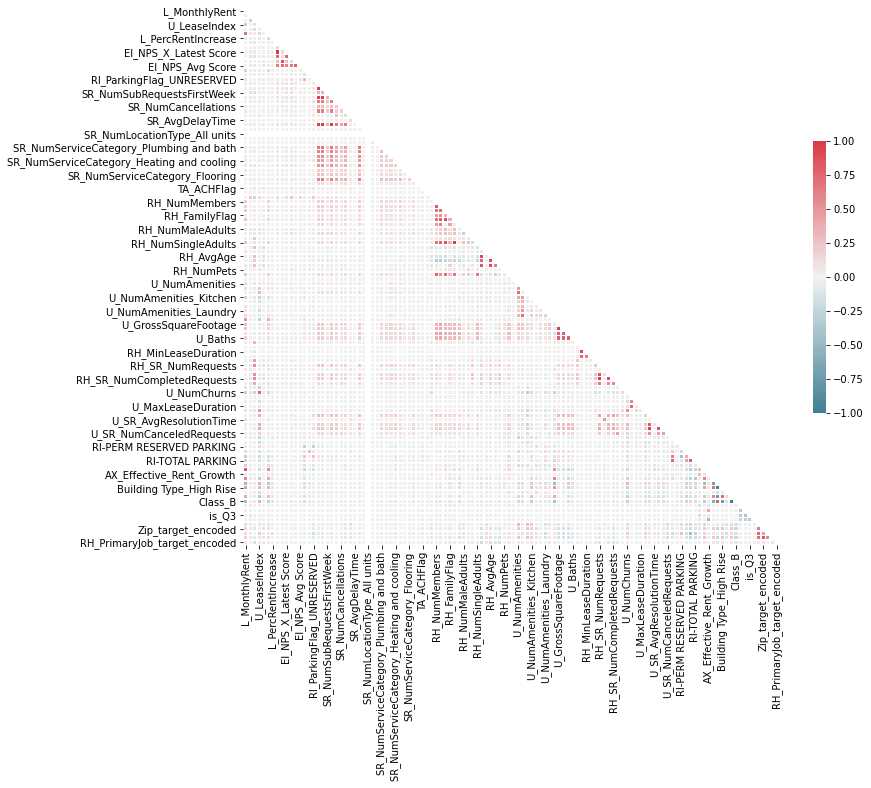

In [46]:
plot_correlation_heatmap(train_data_v19)

<ipython-input-45-375252e59597>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)
<ipython-input-44-5433acfb2c8f>:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


No of columns dropped for high correlation : 18 ['EI_NPS_X_Latest Score', 'EI_NPS_Max Score', 'SR_NumSubRequests', 'SR_NumResolutions', 'SR_NumLocationType_Single unit', 'RH_NumAdults', 'RH_NumSingleAdults', 'RH_AvgAge', 'RH_MinAge', 'RH_MaxAge', 'U_RentableSquareFootage', 'RH_MinLeaseDuration', 'RH_SR_NumDelayedRequests', 'RH_SR_NumCompletedRequests', 'U_SR_NumCompletedRequests', 'Building Type_High Rise', 'Class_B', 'City_target_encoded']


LeaseUID  L_MonthlyRent  L_Duration  RH_LeaseIndex  U_LeaseIndex  \
0       1003904-3746         1103.0          13            1.0          16.0   
1       1003904-3751         1136.0          12           13.0          15.0   
2       1003904-3756         1382.0          12            1.0          14.0   
3       1003904-3759         1135.0          14            1.0          13.0   
4       1003904-3766         1405.0          12            2.0          11.0   
...              ...            ...         ...            ...           ...   
116910  4555777-2125         1665.0          12            1.0           3.0   
116911  4555777-2146         2009.0          12            3.0           3.0   
116912  4555777-2151         1689.0          13            1.0           3.0   
116913  4555777-2184         1840.0          12            3.0           3.0   
116914  4555777-2338         1618.0          12            1.0           3.0   

        L_ChurnFlag  L_PrevRentAmount  L_PercRentIncrease  EI_NumSurveys  \
0                 1            1581.0            0.042868            2.0   
1                 0            1103.0            0.029918            2.0   
2                 0            1581.0            0.042868            2.0   
3                 1            1581.0            0.042868            2.0   
4                 0            1364.0            0.030059            2.0   
...             ...               ...                 ...            ...   
116910            0            1581.0            0.042868            1.0   
116911            1            1962.0            0.023955            2.0   
116912            0            1581.0            0.042868            2.0   
116913            0            1795.0            0.025070            1.0   
116914            1            1581.0            0.042868            2.0   

        EI_NPS_X_First Score  EI_NPS_Min Score  EI_NPS_Avg Score  \
0                        9.0               1.0               5.5   
1                        9.0               1.0               5.5   
2                        9.0               1.0               5.5   
3                        9.0               1.0               5.5   
4                        9.0               1.0               5.5   
...                      ...               ...               ...   
116910                   0.0               0.0               0.5   
116911                   9.0               1.0               5.5   
116912                   9.0               1.0               5.5   
116913                   8.0               1.0               4.5   
116914                   7.0               2.0               6.0   

        RI_ParkingFlag  RI_ParkingFlag_RESERVED  RI_ParkingFlag_UNRESERVED  \
0                  0.0                      0.0                        0.0   
1                  0.0                      0.0                        0.0   
2                  0.0                      0.0                        0.0   
3                  0.0                      0.0                        0.0   
4                  0.0                      0.0                        0.0   
...                ...                      ...                        ...   
116910             1.0                      0.0                        1.0   
116911             1.0                      0.0                        1.0   
116912             1.0                      0.0                        0.0   
116913             1.0                      0.0                        1.0   
116914             1.0                      0.0                        1.0   

        SR_NumRequests  SR_NumSubRequestsFirstWeek  SR_NumDelayedResolutions  \
0                  5.0                         1.0                       1.0   
1                  1.0                         1.0                       0.0   
2                  5.0                         1.0                       1.0   
3                  5.0                         2.0              

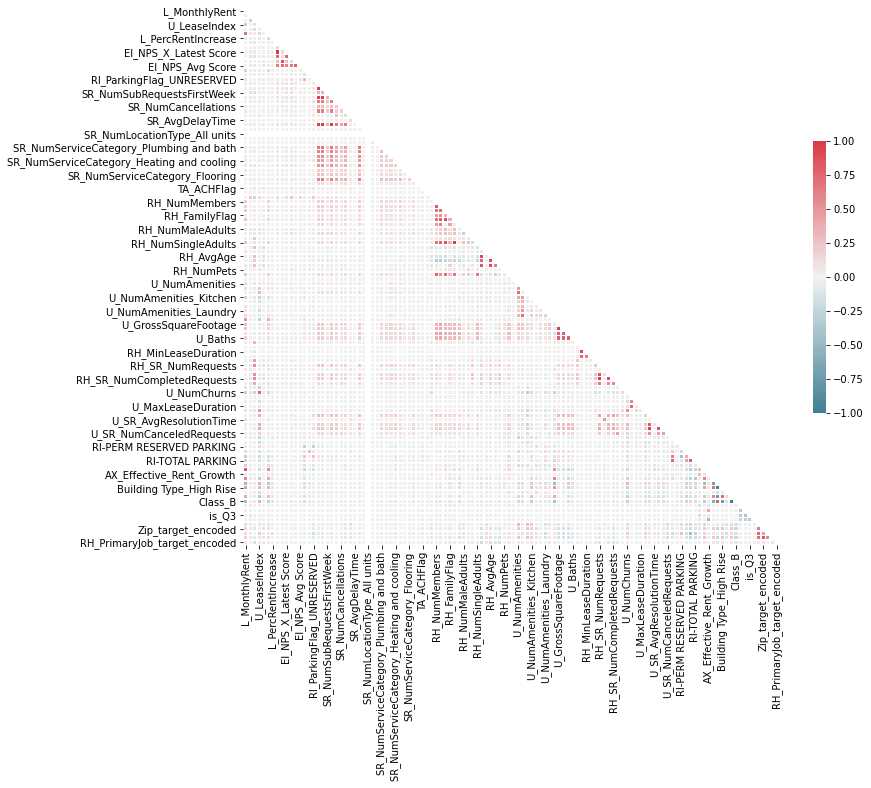

In [47]:
remove_highly_correlated(train_data_v19, corThreshold=0.85, plot=True)

In [48]:
to_drop= ['EI_NPS_X_Latest Score', 'EI_NPS_Max Score', 'SR_NumSubRequests', 'SR_NumResolutions', 'SR_NumLocationType_Single unit', 'RH_NumAdults', 'RH_NumSingleAdults', 'RH_AvgAge', 'RH_MinAge', 'RH_MaxAge', 'U_RentableSquareFootage', 'RH_MinLeaseDuration', 'RH_SR_NumDelayedRequests', 'RH_SR_NumCompletedRequests', 'U_SR_NumCompletedRequests', 'Building Type_High Rise', 'Class_B', 'City_target_encoded']

In [49]:
train_data = train_data_v19.drop(columns=to_drop,axis=1)
valid_data = valid_data_v19.drop(columns=to_drop,axis=1)
test_data = test_data_v19.drop(columns=to_drop,axis=1)
oot_data = oot_data_v19.drop(columns=to_drop,axis=1)

In [50]:
X_train2=train_data.drop(["L_ChurnFlag","LeaseUID"],axis=1)
y_train2=train_data["L_ChurnFlag"]

In [51]:
X_valid2=valid_data.drop(["L_ChurnFlag","LeaseUID"],axis=1)
y_valid2=valid_data["L_ChurnFlag"]

In [63]:
X_test_2=test_data.drop(["L_ChurnFlag","LeaseUID"],axis=1)
y_test_2=test_data["L_ChurnFlag"]

In [62]:
X_oot2=oot_data.drop(["L_ChurnFlag","LeaseUID"],axis=1)
y_oot2=oot_data["L_ChurnFlag"]

In [54]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state = 0,n_jobs=-1)
classifier.fit(X_train2, y_train2)
y_pred2 = classifier.predict(X_valid2)
y_pred_train2=classifier.predict(X_train2)
# Model evaluation
print('train accuracy: ')
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_train2, y_pred_train2)
print(" ")
print('test accuracy: ')
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_valid2, y_pred2)

train accuracy: 
Accuracy Score :  100.0
ROC AUC score :  100.0
Precision score :  100.0
Recall score :  100.0
 
test accuracy: 
Accuracy Score :  63.8
ROC AUC score :  58.93
Precision score :  58.38
Recall score :  34.21


In [55]:
from sklearn.model_selection import RandomizedSearchCV

In [56]:
classifier2 = lightgbm.LGBMClassifier()
classifier2.fit(X_train2, y_train2)
y_pred2 = classifier2.predict(X_valid2)
y_pred_train2=classifier2.predict(X_train2)

# Model evaluation
print('train accuracy: ')
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_train2, y_pred_train2)
print(" ")
print('test accuracy: ')
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_valid2, y_pred2)

train accuracy: 
Accuracy Score :  67.97
ROC AUC score :  63.88
Precision score :  65.02
Recall score :  43.35
 
test accuracy: 
Accuracy Score :  65.16
ROC AUC score :  60.97
Precision score :  59.96
Recall score :  39.75


## Feature Importance

In [57]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(X_train2, y_train2)

RandomForestClassifier()

In [58]:
pd.set_option('display.max_row', None)
rf.feature_importances_
df=pd.DataFrame({"Feature_names":X_train2.columns,"importance":rf.feature_importances_})
df_new=df.sort_values(by="importance",ascending=False)
df_new

Feature_names  importance
44                                      RH_HoHAge    0.040481
0                                   L_MonthlyRent    0.028224
75                         U_SR_AvgResolutionTime    0.027197
86                       AX_Effective_Rent_Growth    0.026327
70                             U_AvgLeaseDuration    0.025969
74                               U_SR_NumRequests    0.024991
84                                   AX_Occupancy    0.024892
85                              AX_Effective_Rent    0.024479
58                           U_GrossSquareFootage    0.023267
76                        U_SR_NumDelayedRequests    0.022717
18                           SR_AvgResolutionTime    0.022505
51                  U_NumAmenities_Unit Amenities    0.021670
49                                 U_NumAmenities    0.019888
45                            RH_DistanceFromWork    0.019090
48                                 RH_TotalSalary    0.018668
13                                 SR_NumRequests    0.017277
3                                    U_LeaseIndex    0.017253
19                                SR_AvgDelayTime    0.017167
96                             Zip_target_encoded    0.017149
69                                    U_NumChurns    0.017066
5                              L_PercRentIncrease    0.016575
65                              RH_SR_NumRequests    0.016351
4                                L_PrevRentAmount    0.016006
2                                   RH_LeaseIndex    0.015370
71                             U_MinLeaseDuration    0.015223
66                        RH_SR_AvgResolutionTime    0.014615
9                                EI_NPS_Avg Score    0.014574
77                       U_SR_NumCanceledRequests    0.013761
78                                      UnitCount    0.012919
17                         SR_NumEarlyResolutions    0.012666
72                             U_MaxLeaseDuration    0.012129
73                                 U_NumMTMLeases    0.012061
57                                        U_Floor    0.011857
83                               RI-TOTAL PARKING    0.011708
24        SR_NumServiceCategory_Plumbing and bath    0.011640
33                                     TA_ACHFlag    0.011615
98                   RH_PrimaryJob_target_encoded    0.011044
25                SR_NumServiceCategory_Appliance    0.010688
15                       SR_NumDelayedResolutions    0.010521
50                             U_NumAmenityGroups    0.010393
82                          RI-UNRESERVED PARKING    0.010325
7                            EI_NPS_X_First Score    0.009705
80                       RI-PERM RESERVED PARKING    0.009414
81                            RI-RESERVED PARKING    0.009404
62                            RH_AvgLeaseDuration    0.009394
26  SR_NumServiceCategory_Electrical and lighting    0.009141
1                                      L_Duration    0.009097
31                  SR_NumServiceCategory_General    0.008603
95                          Market_target_encoded    0.008601
52                         U_NumAmenities_Kitchen    0.008588
27      SR_NumServiceCategory_Heating and cooling    0.008130
56                          U_NumAmenities_Others    0.008095
28          SR_NumServiceCategory_Doors and locks    0.007745
36                                  RH_NumMembers    0.007357
47                                 RH_NumEmployed    0.006663
37                                RH_NumOccupants    0.006637
97                           State_target_encoded    0.006605
63                            RH_MaxLeaseDuration    0.006300
8                                EI_NPS_Min Score    0.006251
68                                 U_NumTransfers    0.006066
42                             RH_NumFemaleAdults    0.005902
6                                   EI_NumSurveys    0.005828
54                   U_NumAmenities_Patio/Balcony    0.005675
41                               RH_NumMaleAdults    0.005620
46    

In [59]:
len(df_new)

99

In [60]:
imp_features=[]

for i in df_new['Feature_names'][:50]:
    imp_features.append(i)
imp_features

['RH_HoHAge',
 'L_MonthlyRent',
 'U_SR_AvgResolutionTime',
 'AX_Effective_Rent_Growth',
 'U_AvgLeaseDuration',
 'U_SR_NumRequests',
 'AX_Occupancy',
 'AX_Effective_Rent',
 'U_GrossSquareFootage',
 'U_SR_NumDelayedRequests',
 'SR_AvgResolutionTime',
 'U_NumAmenities_Unit Amenities',
 'U_NumAmenities',
 'RH_DistanceFromWork',
 'RH_TotalSalary',
 'SR_NumRequests',
 'U_LeaseIndex',
 'SR_AvgDelayTime',
 'Zip_target_encoded',
 'U_NumChurns',
 'L_PercRentIncrease',
 'RH_SR_NumRequests',
 'L_PrevRentAmount',
 'RH_LeaseIndex',
 'U_MinLeaseDuration',
 'RH_SR_AvgResolutionTime',
 'EI_NPS_Avg Score',
 'U_SR_NumCanceledRequests',
 'UnitCount',
 'SR_NumEarlyResolutions',
 'U_MaxLeaseDuration',
 'U_NumMTMLeases',
 'U_Floor',
 'RI-TOTAL PARKING',
 'SR_NumServiceCategory_Plumbing and bath',
 'TA_ACHFlag',
 'RH_PrimaryJob_target_encoded',
 'SR_NumServiceCategory_Appliance',
 'SR_NumDelayedResolutions',
 'U_NumAmenityGroups',
 'RI-UNRESERVED PARKING',
 'EI_NPS_X_First Score',
 'RI-PERM RESERVED PARKING',

In [61]:
train_data2 = train_data.loc[:,imp_features]
valid_data2=valid_data.loc[:, imp_features]
test_data2=test_data.loc[:, imp_features]
oot_data2=oot_data.loc[:, imp_features]

In [74]:
train_data["L_ChurnFlag"].dtypes

dtype('int32')

In [68]:
X_train3=train_data2[:]
y_train3=train_data["L_ChurnFlag"]

In [70]:
X_valid3=valid_data2[:]
y_valid3=valid_data["L_ChurnFlag"]

In [71]:
X_test3=test_data2[:]
y_test3=test_data["L_ChurnFlag"]

In [72]:
X_oot3=oot_data2[:]
y_oot3=oot_data["L_ChurnFlag"]

In [73]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state = 0,n_jobs=-1)
classifier.fit(X_train3, y_train3)
y_pred3 = classifier.predict(X_valid3)
y_pred_train3=classifier.predict(X_train3)
# Model evaluation
print('train accuracy: ')
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_train3, y_pred_train3)
print(" ")
print('valid accuracy: ')
acc_score, roc_score, prec_score, rec_score = evaluate_model(X_valid3, y_pred3)

train accuracy: 
Accuracy Score :  100.0
ROC AUC score :  100.0
Precision score :  100.0
Recall score :  100.0
 
valid accuracy: 


ValueError: Classification metrics can't handle a mix of continuous-multioutput and binary targets

In [75]:
classifier2 = lightgbm.LGBMClassifier()
classifier2.fit(X_train3, y_train3)
y_pred2 = classifier2.predict(X_valid3)
y_pred_train2=classifier2.predict(X_train3)

# Model evaluation
print('train accuracy: ')
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_train3, y_pred_train2)
print(" ")
print('test accuracy: ')
acc_score, roc_score, prec_score, rec_score = evaluate_model(y_valid3, y_pred2)

train accuracy: 
Accuracy Score :  67.16
ROC AUC score :  62.97
Precision score :  63.66
Recall score :  41.94
 
test accuracy: 
Accuracy Score :  64.35
ROC AUC score :  60.11
Precision score :  58.48
Recall score :  38.61
